# Importing libraries

In [2]:
import requests
import pandas as pd
import numpy as np
import xml.dom.minidom as parser
from bs4 import BeautifulSoup as bs

import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
import sklearn

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

# Importing libraries
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd

2022-09-19 03:57:22.233759: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-19 03:57:22.920304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-19 03:57:22.920361: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Data Processing

### Data Collection

Roll-call votes are pulled from senate.gov and associated bills are pulled from congress.gov. 

In [3]:
total_bills = []
total_votes = []
count = 0

for senate in range(101, 118):
  for session in [1,2]:

    response_0 = requests.get(f"https://www.senate.gov/legislative/LIS/roll_call_lists/vote_menu_{senate}_{session}.xml")
    tree = parser.parseString(response_0.text)
    votes = tree.documentElement.getElementsByTagName("vote")

    for vote in votes:
      try:
        issue = vote.getElementsByTagName("issue")[0].childNodes[0].data.strip().split()
        vote_number = vote.getElementsByTagName("vote_number")[0].childNodes[0].data.strip()
        question = vote.getElementsByTagName("question")[0].childNodes[0].data.strip()
        if (question != "On Passage of the Bill"):
          continue
        if (issue[0] in ["S.", "H.R."]):

          response_1 = requests.get(f"https://www.senate.gov/legislative/LIS/roll_call_votes/vote{senate}{session}/vote_{senate}_{session}_{vote_number}.xml")
          tree = parser.parseString(response_1.text)
          members = tree.documentElement.getElementsByTagName("member")

          roll_call = list(filter(lambda member: member.getElementsByTagName("last_name")[0].childNodes[0].data.strip() == "Leahy", members))[0]
          if (len(roll_call.getElementsByTagName("vote_cast")) == 0):
            continue
          else:
            roll = roll_call.getElementsByTagName("vote_cast")[0].childNodes[0].data
            if (roll == 'Yea'):
              vote_b = 1
            else:
              vote_b = 0


          if (issue[0] == "S."):
            congress = "senate"
          else:
            congress = "house"

          response_2 = requests.get(f"https://www.congress.gov/bill/{senate}th-congress/{congress}-bill/{issue[1]}/text?format=txt")
          try:
            bill = bs(response_2.text).find("pre").get_text()
          except:
            continue

          count += 1
          if (count % 10 == 0):
            print(f"{senate} {session}: {count}")
          total_bills.append(bill)
          total_votes.append(vote_b)
      except:
        continue

101 1: 10
101 2: 20
102 1: 30
102 2: 40
103 1: 50
103 2: 60
104 1: 70
104 1: 80
104 1: 90
104 2: 100
104 2: 110
104 2: 120
105 2: 130
105 2: 140
105 2: 150
106 1: 160
106 1: 170
106 2: 180
106 2: 190
106 2: 200
107 1: 210
107 1: 220
107 1: 230
107 2: 240
107 2: 250
108 1: 260
108 1: 270
108 1: 280
108 2: 290
108 2: 300
109 1: 310
109 1: 320
109 2: 330
109 2: 340
109 2: 350
110 1: 360
110 1: 370
110 1: 380
110 2: 390
110 2: 400
111 1: 410
111 1: 420
111 1: 430
111 2: 440
112 1: 450
112 2: 460
112 2: 470
113 1: 480
113 2: 490
114 1: 500
114 1: 510
114 2: 520
114 2: 530
115 1: 540
116 1: 550
116 1: 560
116 2: 570
117 1: 580
117 2: 590


### Data Cleaning

Reformatting the XML votes of 'Yea' or 'Nay' to a binary 1 or 0, respectively

In [4]:
# reformat the roll-call votes

votes = list(map(lambda vote: vote.getElementsByTagName("vote_cast"), votes))

Y_data = list(map(lambda vote: 1 if vote == "Yea" else 0, votes))



Evaluating the Always-Yes predictive strategy

In [5]:
sum(total_votes) / len(total_votes)


0.8232323232323232

Removing the zero-meaning words from all of the bills. Because we are not using sentence structure/word order, and just what words are present in the bill, this won't change the "meaning" of the bill, in the eyes of the neural network.

Our zero-meaning words are pulled from two sources. The first is the top 100 most frequent unigram (single word) in the English language. General inspection was done to decide the cut-off from the list, as the top 100 is an arbitrary choice. The second is a list of English stopwords, which are defined to be words that carry no meaning.

In [6]:
import json
# Getting negative data cleaning

top_100_unigrams = pd.read_csv('frequency/unigram_freq.csv').iloc[:101]['word'].to_list()
stopwords = json.loads(open('frequency/stop-words-english.json').read())

null_words = set(top_100_unigrams + stopwords)

for i, bill in enumerate(total_bills):
    total_bills[i] = ' '.join(filter(lambda x: x.lower() not in null_words, bill.split()))


Removing an special characters that come with text data

In [7]:
# Preprocessing
def remove_string_special_characters(s):
      
    # removes special characters with ' '
    stripped = re.sub('[^a-zA-z\s]', '', s)
    stripped = re.sub('_', '', stripped)
      
    # Change any white space to one space
    stripped = re.sub('\s+', ' ', stripped)
      
    # Remove start and end white spaces
    stripped = stripped.strip()
    if stripped != '':
            return stripped.lower()

bills = list(map(remove_string_special_characters, total_bills))

### Data Processing

Finding the Term Frequency - Inverse Document Frequency for both unigrams and bigrams

In [8]:
def get_TFIDF(ngram):
    # Getting ngrams
    vectorizer = CountVectorizer(ngram_range = (ngram,ngram))
    x1 = vectorizer.fit_transform(bills)
    features = (vectorizer.get_feature_names_out())

    # Applying TFIDF
    vectorizer = TfidfVectorizer(ngram_range = (ngram,ngram))
    x2 = vectorizer.fit_transform(bills)
    scores = (x2.toarray())

    # Getting top ranking features
    sums = x2.sum(axis = 0)
    data1 = []
    for col, term in enumerate(features):
        data1.append( (term, sums[0,col] ))
    ranking = pd.DataFrame(data1, columns = ['term','rank'])
    words = (ranking.sort_values('rank', ascending = False))
    return words.iloc[:4001]['term'].to_list()

In [9]:
unigrams = get_TFIDF(1)
bigrams = get_TFIDF(2)

Sorting to get the top 4000 n-grams from all the bills.

In [11]:
# Get the uni- and bi- gram frequencies

bigram_freq = {}
unigram_freq = {}

for bill in bills:

    for unigram in bill.split():
        unigram_freq[unigram] = unigram_freq.get(unigram,0) + 1

    for bigram in list(nltk.bigrams(bill.split())):
        bigram_freq[bigram] = bigram_freq.get(bigram,0) + 1

# Get the top K most frequent n-gram features
K = 4000

unigrams = list({key: val for key, val in sorted(unigram_freq.items(), key = lambda ele: ele[1], reverse = True)})[0:K]
bigrams = list(map(lambda x: x[0] + ' ' + x[1], list({key: val for key, val in sorted(bigram_freq.items(), key = lambda ele: ele[1], reverse = True)})[0:K]))

In [11]:
def binary_feature_map(documents, features):
    x = []
    for doc in documents:
        x1 = []
        for feat in features:
            if (doc.find(feat) != -1):
                x1.append(1)
            else:
                x1.append(0)
        x.append(x1)
    return x

def bag_feature_map(documents, features):
    x = []
    for doc in documents:
        x1 = []
        for feat in features:
            x1.append(doc.count(feat))
        x.append(x1)
    return x

Processing each bill's text to create 4000-dimension vectors to represent the bill. For the binary features, we are seeing whether a unigram or bigram in found in the bill or not. For the bag-of-words, we are looking at the count of that unigram or bigram in that bill.

In [12]:
# Creating the binary features for the top unigrams for each bill
X_uni_binary = binary_feature_map(bills, unigrams)

# Creating the binary features for the top bigrams for each bill
X_bi_binary = binary_feature_map(bills, bigrams)

In [13]:
# Creating the bag-of-words count for the top unigrams for each bill
X_uni_bag = bag_feature_map(bills, unigrams)

# Creating the bag-of-words count for the top bigrams for each bill
X_bi_bag = bag_feature_map(bills, bigrams)

In [14]:
import csv

def create_CSV(data, path):
    with open(path, 'x') as f:
        write = csv.writer(f)
        write.writerows(data)

In [18]:
data_votes = list(map(lambda x: [x], total_votes))
Y_data = total_votes

In [16]:
create_CSV(X_uni_binary, 'data/uni_binary_small_tfidf.CSV')
create_CSV(X_uni_bag, 'data/uni_bag_small_tfidf.CSV')
create_CSV(X_bi_binary, 'data/bi_binary_small_tfidf.CSV')
create_CSV(X_bi_bag, 'data/bi_bag_small_tfidf.CSV')

In [17]:
create_CSV(data_votes, 'data/votes_small_tfidf.CSV')
create_CSV(unigrams, 'data/unigrams_small_tfidf.CSV')
create_CSV(bigrams, 'data/bigrams_small_tfidf.CSV')

# Building the Neural Network

In [9]:
# importing the processed data

X_uni_binary = pd.read_csv('data/uni_binary.CSV').to_numpy()
X_bi_binary = pd.read_csv('data/bi_binary.CSV').to_numpy()
X_uni_bag = pd.read_csv('data/uni_binary.CSV').to_numpy()
X_bi_bag = pd.read_csv('data/bi_binary.CSV').to_numpy()

Y_data = pd.read_csv('data/votes.CSV').to_numpy().flatten()

In [208]:
X_uni_binary = pd.read_csv('data/uni_binary_small.CSV').to_numpy()
X_bi_binary = pd.read_csv('data/bi_binary_small.CSV').to_numpy()
X_uni_bag = pd.read_csv('data/uni_binary_small.CSV').to_numpy()
X_bi_bag = pd.read_csv('data/bi_binary_small.CSV').to_numpy()

Y_data = pd.read_csv('data/votes_small.CSV').to_numpy().flatten()

In [19]:
def model_train_test_split(x_data, y_data):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, stratify=y_data, random_state=0)
    return [x_train, x_test, y_train, y_test]

In [20]:
# Unigram Binary Features
unigram_binary = model_train_test_split(X_uni_binary, Y_data)

# Bigram Binary Features
bigram_binary = model_train_test_split(X_bi_binary, Y_data)

# Unigram Bag-of-Words Features
unigram_bag = model_train_test_split(X_uni_bag, Y_data)

# Bigram Bag-of-Words Features
bigram_bag = model_train_test_split(X_bi_bag, Y_data)

In [21]:
def print_dimensions(name, data):
    print(name)
    print('X_train:',np.shape(data[0]))
    print('y_train:',np.shape(data[2]))
    print('X_test:',np.shape(data[1]))
    print('y_test:',np.shape(data[3]))
    print('\n')

In [22]:
print_dimensions('Unigram Binary', unigram_binary)
print_dimensions('Bigram Binary', bigram_binary)
print_dimensions('Unigram Bag', unigram_bag)
print_dimensions('Bigram Bag', bigram_bag)

Unigram Binary
X_train: (504, 4001)
y_train: (504,)
X_test: (90, 4001)
y_test: (90,)


Bigram Binary
X_train: (504, 4001)
y_train: (504,)
X_test: (90, 4001)
y_test: (90,)


Unigram Bag
X_train: (504, 4001)
y_train: (504,)
X_test: (90, 4001)
y_test: (90,)


Bigram Bag
X_train: (504, 4001)
y_train: (504,)
X_test: (90, 4001)
y_test: (90,)




In [23]:
import keras
from keras.models import Sequential   # importing Sequential model
from keras.layers import Dense        # importing Dense layers

In [78]:
def create_model():  
    # declaring model

    basic_model = Sequential()

    # Adding layers to the model

    # Hidden Layers
    basic_model.add(Dense(units=2000, activation='relu', input_dim=4001))

    """
    basic_model.add(Dense(units = 1000, activation = 'relu', input_dim = 2000))
    basic_model.add(Dense(units = 500, activation = 'relu', input_dim = 1000))
    basic_model.add(Dense(units=250, activation='relu', input_dim=500))
    basic_model.add(Dense(units=125, activation='relu', input_dim=250))
    basic_model.add(Dense(units = 63, activation = 'relu', input_dim = 125))
    """

    # Output Layer
    basic_model.add(Dense(1, activation = 'sigmoid'))

    # compiling the model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    #opt = tf.keras.optimizers.SGD(learning_rate=0.001)

    basic_model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
    basic_model.summary()

    return basic_model

In [25]:
def train_test_model(data, model, epochs, batch_size):

    # training the model
    model.fit(data[0], data[2], epochs=epochs, batch_size=batch_size)

    # Test, Loss and accuracy
    loss_and_metrics = model.evaluate(data[1], data[3])

    print('Loss = ',loss_and_metrics[0])
    print('Accuracy = ',loss_and_metrics[1])

    return loss_and_metrics[0], loss_and_metrics[1]

An Always-Yes model for the big data would give an accuracy of 0.6361980460341116

An Always-Yes model for the small data would give an accuracy of 0.819614711033275

An Always-Yes model for the small data would give an accuracy of 0.8232323232323232

In [29]:
for x in [X_uni_binary, X_bi_binary, X_uni_bag, X_bi_bag]:

    loss = []
    accuracy = []

    for i in range(10):

        data = model_train_test_split(x, Y_data)
        l, a = train_test_model(data, create_model(), 20, 150)
        loss.append(l)
        accuracy.append(a)

    print('Average Loss = ', sum(loss) / len(loss))
    print('Average Accuracy = ', sum(accuracy) / len(accuracy))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 2000)              8004000   
                                                                 
 dense_25 (Dense)            (None, 1)                 2001      
                                                                 
Total params: 8,006,001
Trainable params: 8,006,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
4/4 [==============================] - 0s 29ms/step - loss: 4.5997 - accuracy: 0.6508
Epoch 2/20
4/4 [==============================] - 0s 31ms/step - loss: 1.7966 - accuracy: 0.8234
Epoch 3/20
4/4 [==============================] - 0s 33ms/step - loss: 0.6618 - accuracy: 0.6389
Epoch 4/20
4/4 [==============================] - 0s 31ms/step - loss: 0.4979 - accuracy: 0.8234
Epoch 5/20
4/4 [==============================] - 0

In [82]:
data = bigram_binary

In [88]:
plt.rc('font', size=15) #controls default text size
plt.rc('axes', titlesize=15) #fontsize of the title
plt.rc('axes', labelsize=15) #fontsize of the x and y labels
plt.rc('xtick', labelsize=15) #fontsize of the x tick labels
plt.rc('ytick', labelsize=15) #fontsize of the y tick labels
plt.rc('legend', fontsize=15) #fontsize of the legend

In [ ]:
model = create_model()
hist = model.fit(data[0], data[2], validation_data=(data[1],data[3]), epochs=50, batch_size=200)

sns.set()
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)


[]

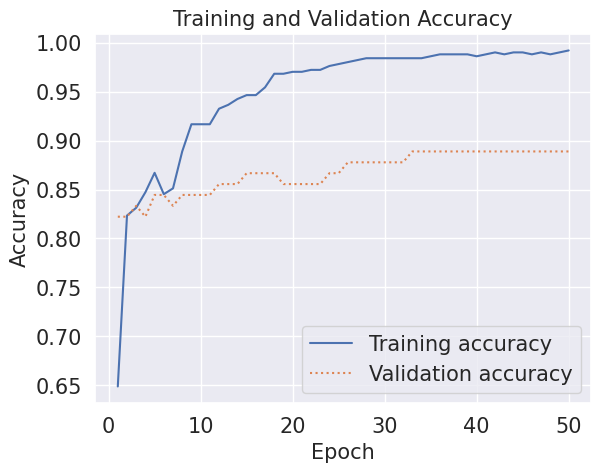

In [89]:
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

3/3 [==============================] - 0s 4ms/step


Text(104.44999999999997, 0.5, 'Actual label')

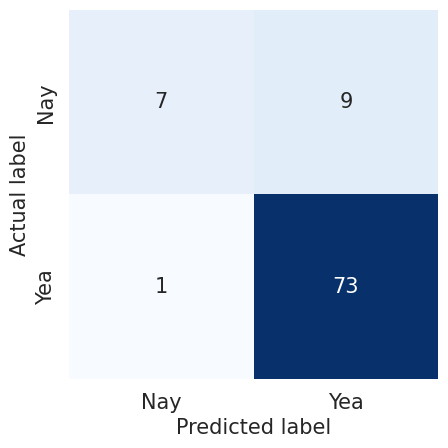

In [90]:
y_predicted = model.predict(data[1]) > 0.5
mat = confusion_matrix(data[3], y_predicted)
labels = ['Nay', 'Yea']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')